# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
random_state=12345

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [3]:
df.shape
# shapes

(26496, 2)

In [4]:
# top 5 
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:

df.info() # general info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# duration of the dataset
df['datetime'].min(), df['datetime'].max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

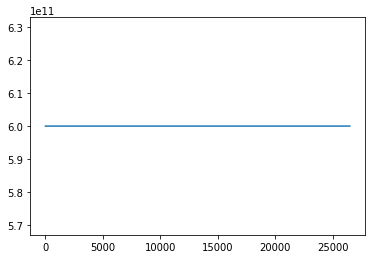

In [8]:
# check for gaps
(df['datetime'] - df['datetime'].shift()).plot()
plt.show()

In [9]:
df.index.unique().shape

(26496,)

### Conclusion

    There are 26496 orders captured at 10 minute intervals from 2018-03-01 to 2018-08-31. Also there are no duplicates or missing values, and the dataset is time ordered with no gaps. 

## Preparation and Analysis

In [10]:
# predictions are required for the next hour
df_hourly = df.copy(deep=True)
df_hourly.set_index('datetime', inplace=True)
df_hourly = df_hourly.resample('1H').sum()

In [11]:
def create_ts_features(df, dt_field, target, max_lag=1, rolling_window=1):
    """
    Create several Timseries features
    """
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)
    
    df['rolling_mean'] = df[target].shift().rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift().rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift().rolling(rolling_window).std()

In [12]:
create_ts_features(df_hourly, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [13]:
df_hourly.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857,66.0,41.558908
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.571429,43.0,32.118827


In [14]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   float64
 6   lag_2           4414 non-null   float64
 7   lag_3           4413 non-null   float64
 8   lag_4           4412 non-null   float64
 9   lag_5           4411 non-null   float64
 10  lag_6           4410 non-null   float64
 11  lag_7           4409 non-null   float64
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   float64
 14  rolling_std     4409 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 552.0 KB


In [15]:
cols_to_change = ['rolling_median', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'
]
df_hourly[cols_to_change] = df_hourly[cols_to_change].astype('Int64')

In [16]:
# after the change
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   Int64  
 6   lag_2           4414 non-null   Int64  
 7   lag_3           4413 non-null   Int64  
 8   lag_4           4412 non-null   Int64  
 9   lag_5           4411 non-null   Int64  
 10  lag_6           4410 non-null   Int64  
 11  lag_7           4409 non-null   Int64  
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   Int64  
 14  rolling_std     4409 non-null   float64
dtypes: Int64(8), float64(2), int64(5)
memory usage: 586.5 KB


In [17]:
def plot_orders(dfs, field, r=1, c=1, figsize=(12, 10), is_mean_window=False,
                window=1, titles=[], sup_title=None):
    """
    Plot mean orders based on different time intervals
    """
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax, label='hourly trend')
            sns.lineplot(df.index, df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.index, df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [18]:
# resample the dataframe on an hourly, daily, and monthly basis
hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

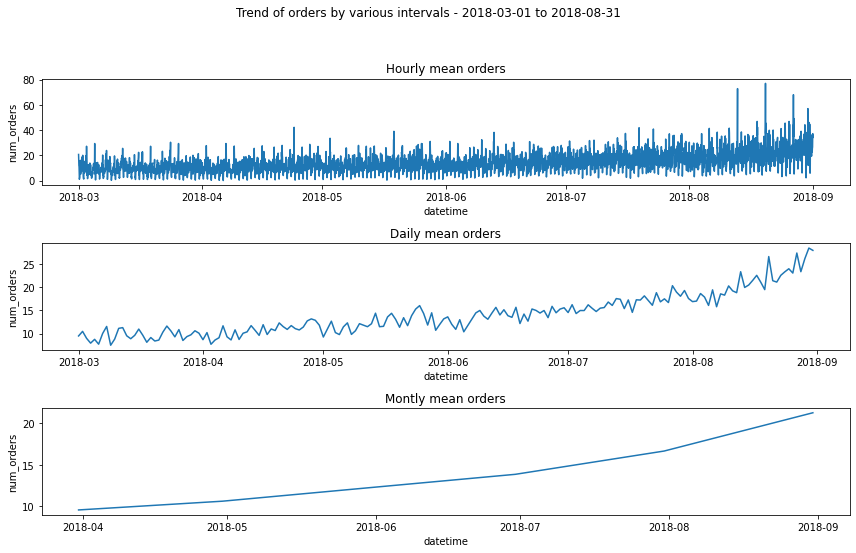

In [19]:
resample_df_list = [hourly_orders, daily_orders, monthly_orders]
titles = ['Hourly mean orders',
         'Daily mean orders',
         'Montly mean orders'
         ]
sup_title = 'Trend of orders by various intervals - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=4, c=1, titles=titles, sup_title=sup_title)

### Summary
    there is definitely doing a upward trend between the dates the data encompasses

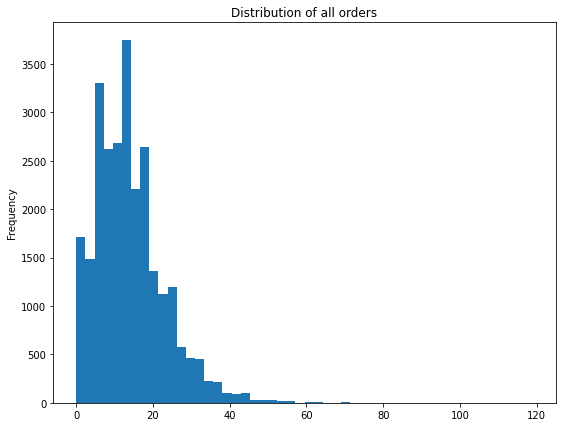

In [20]:
plt.subplots(figsize=(9, 7))
df['num_orders'].plot(kind='hist', bins=50, title='Distribution of all orders')
plt.show()

### Summary
    This histogram shows there are peaks at about 9-12 orders.

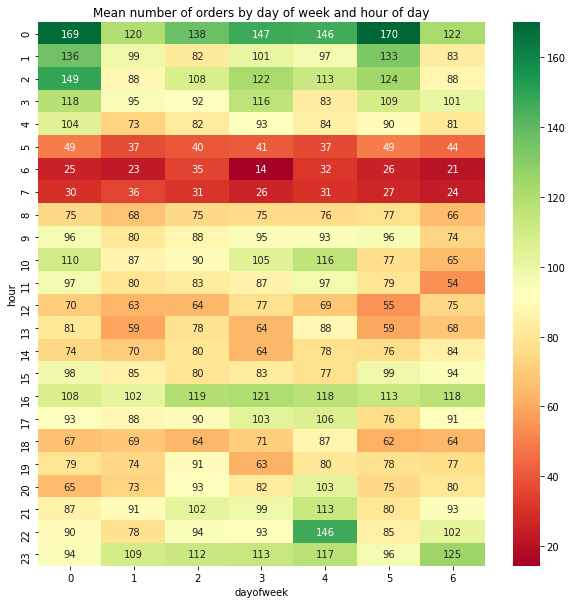

In [21]:
pivoted_df = df_hourly.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="RdYlGn", fmt=".0f")
plt.title('Mean number of orders by day of week and hour of day')
plt.show()

### Summary
    This heat map really breaks down everything really well. It shows there is a huge drop in request from 5 am to 7 am each day which is consistantly low for the whole week. It discloses a very busy time is 12 am which is way higher of an average then any other time. 

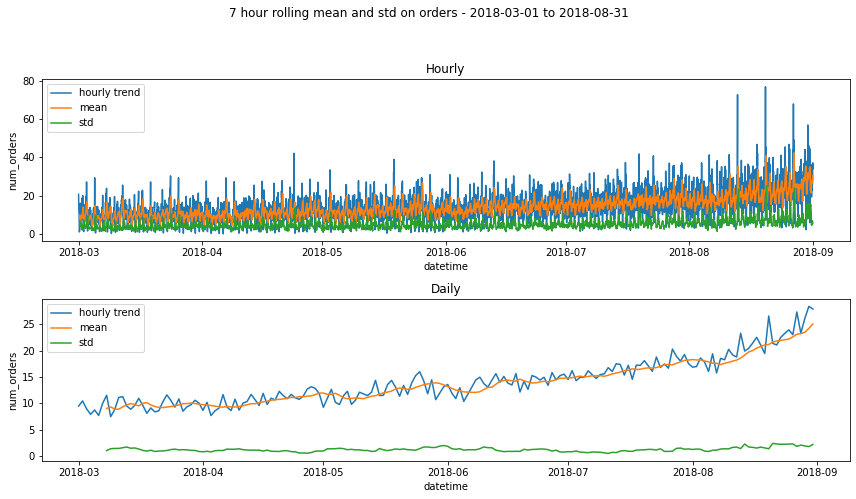

In [22]:
resample_df_list = [hourly_orders, daily_orders]
titles = [
         'Hourly',
         'Daily'
         ]
window = 7
sup_title = f'{window} hour rolling mean and std on orders - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=3, c=1, is_mean_window=True, window=window, 
            titles=titles, sup_title=sup_title)

### Summary
    The hourly data is all over the place the 7 hour mean and std are also all over the place. However in the daily orders the std appears constant and the mean is more consistant.

In [23]:
df_hourly = df_hourly.dropna()

In [24]:
df_hourly.shape

(4409, 15)

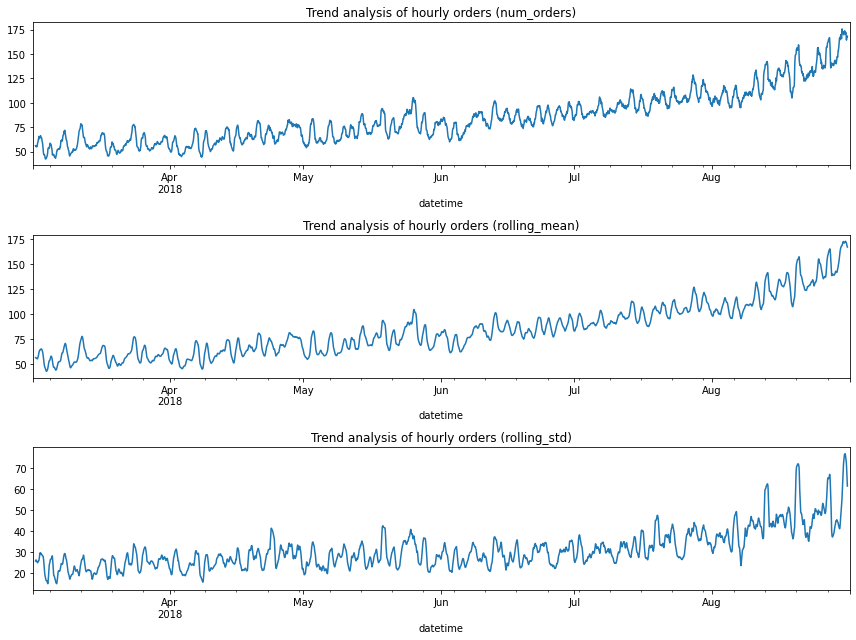

In [25]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Decompose 'num_orders'
decomposed_num_orders = seasonal_decompose(df_hourly['num_orders'])
decomposed_rolling_mean = seasonal_decompose(df_hourly['rolling_mean'])
decomposed_rolling_std = seasonal_decompose(df_hourly['rolling_std'])

# Plot the trend component for 'num_orders'
decomposed_num_orders.trend.plot(ax=axes[0], title='Trend analysis of hourly orders (num_orders)')

# Plot the trend component for 'rolling_mean'
decomposed_rolling_mean.trend.plot(ax=axes[1], title='Trend analysis of hourly orders (rolling_mean)')

# Plot the trend component for 'rolling_std'
decomposed_rolling_std.trend.plot(ax=axes[2], title='Trend analysis of hourly orders (rolling_std)')

plt.tight_layout()
plt.show()


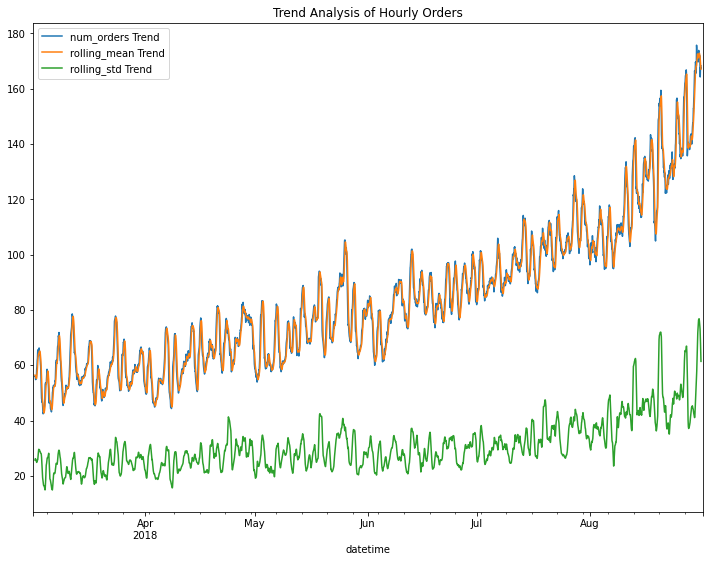

In [26]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 9))

# Decompose 'num_orders'
decomposed_num_orders = seasonal_decompose(df_hourly['num_orders'])
decomposed_rolling_mean = seasonal_decompose(df_hourly['rolling_mean'])
decomposed_rolling_std = seasonal_decompose(df_hourly['rolling_std'])

# Plot the trend components of 'num_orders', 'rolling_mean', and 'rolling_std'
decomposed_num_orders.trend.plot(ax=ax, label='num_orders Trend')
decomposed_rolling_mean.trend.plot(ax=ax, label='rolling_mean Trend')
decomposed_rolling_std.trend.plot(ax=ax, label='rolling_std Trend')

ax.set_title('Trend Analysis of Hourly Orders')
ax.legend()
plt.show()

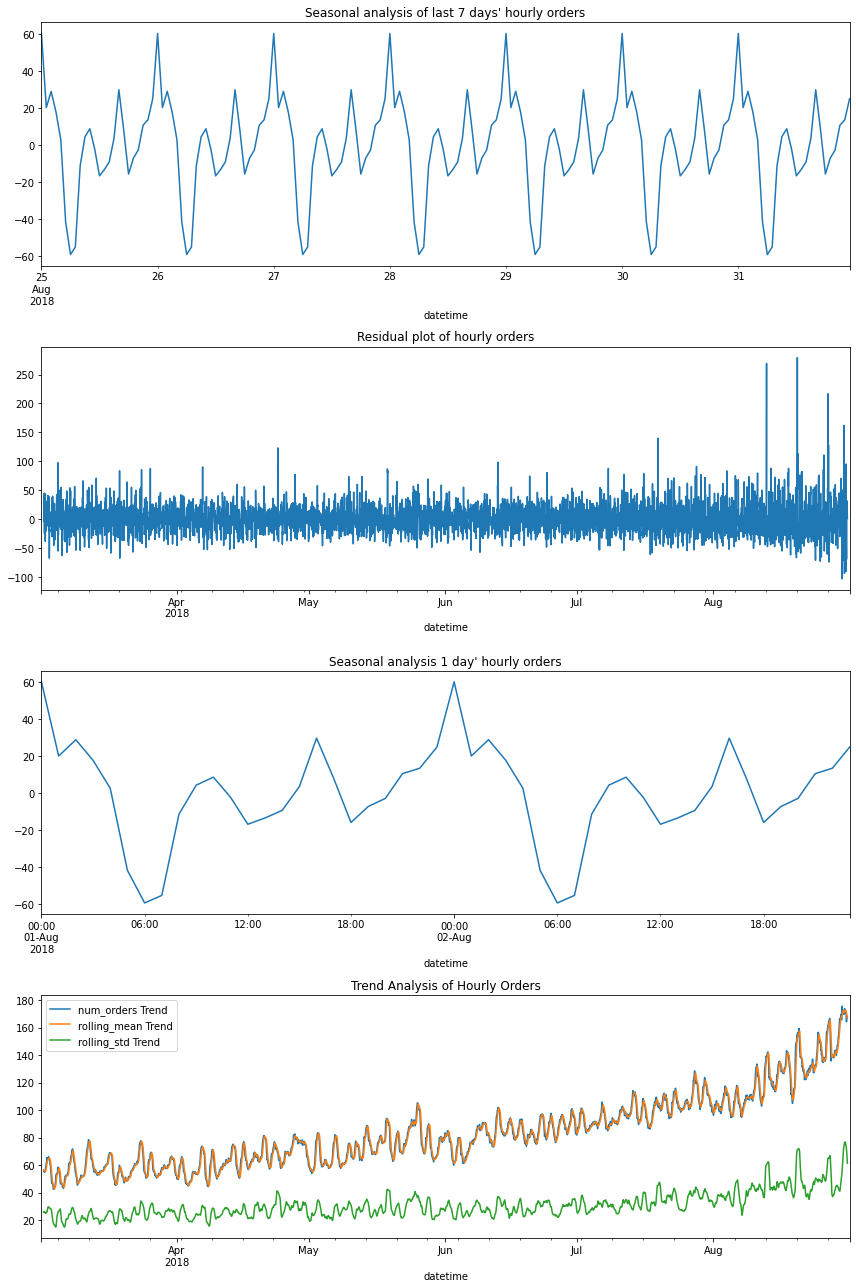

In [27]:
# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 18))

# Decompose 'num_orders'
decomposed_num_orders = seasonal_decompose(df_hourly['num_orders'])
decomposed_rolling_mean = seasonal_decompose(df_hourly['rolling_mean'])
decomposed_rolling_std = seasonal_decompose(df_hourly['rolling_std'])

# Plot the seasonal component for the last 7 days
decomposed_num_orders.seasonal.tail(24*7).plot(ax=axes[0], title="Seasonal analysis of last 7 days' hourly orders")

# Plot the residual component
decomposed_num_orders.resid.plot(ax=axes[1], title="Residual plot of hourly orders")

# Plot the seasonal component for a specific date range
decomposed_num_orders.seasonal['2018-08-01': '2018-08-02'].plot(ax=axes[2], title="Seasonal analysis 1 day' hourly orders")

# Plot the trend components of 'num_orders', 'rolling_mean', and 'rolling_std' on the same graph
decomposed_num_orders.trend.plot(ax=axes[3], label='num_orders Trend')
decomposed_rolling_mean.trend.plot(ax=axes[3], label='rolling_mean Trend')
decomposed_rolling_std.trend.plot(ax=axes[3], label='rolling_std Trend')

axes[3].set_title('Trend Analysis of Hourly Orders')
axes[3].legend()

plt.tight_layout()
plt.show()

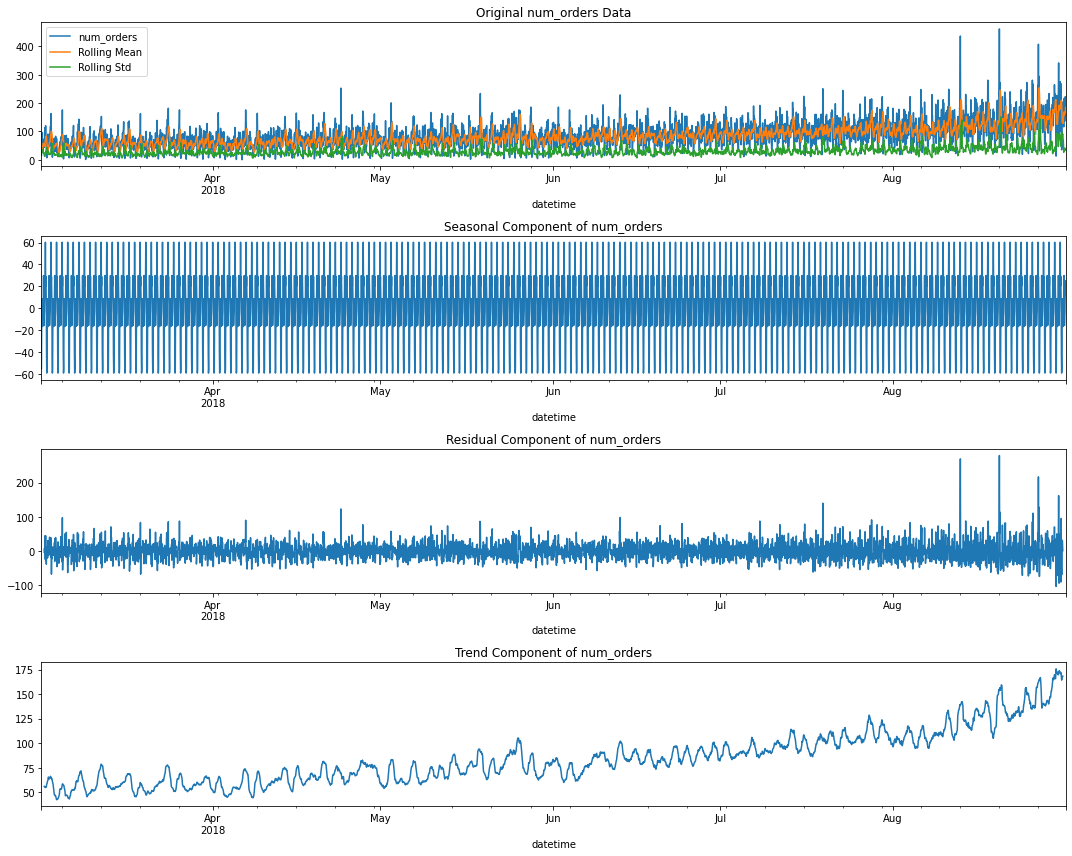

In [28]:
# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original 'num_orders' data
df_hourly['num_orders'].plot(ax=axes[0], title='Original num_orders Data')

# Rolling mean and rolling std
df_hourly['rolling_mean'].plot(ax=axes[0], label='Rolling Mean')
df_hourly['rolling_std'].plot(ax=axes[0], label='Rolling Std')
axes[0].legend()

# Plot the seasonal component for 'num_orders'
decomposed_num_orders.seasonal.plot(ax=axes[1], title='Seasonal Component of num_orders')

# Plot the residual component for 'num_orders'
decomposed_num_orders.resid.plot(ax=axes[2], title='Residual Component of num_orders')

# Plot the trend component for 'num_orders'
decomposed_num_orders.trend.plot(ax=axes[3], title='Trend Component of num_orders')

plt.tight_layout()
plt.show()

## Training and Testing

In [29]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [30]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [31]:
# split the dataframe
train_X, test_X, train_y, test_y = train_test_split(df_hourly.drop(['num_orders'], axis=1), 
                                              df_hourly['num_orders'], 
                                              test_size=0.2,
                                              random_state=42, shuffle=False)

In [32]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((3527, 14), (882, 14), (3527,), (882,))

In [33]:
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=tscv)

# Print the results
print("Linear Regression Model Results:")
print("Best RMSE:", best_lr_rmse)
print("Training Time:", best_lr_time)


Linear Regression Model Results:
Best RMSE: 48.61659695472257
Training Time: 0.29


In [35]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(rmse), cv=tscv)

# Print the results
print("Random Forest Regressor Model Results:")
print("Best RMSE:", best_rf_rmse)
print("Training Time:", best_rf_time)

Random Forest Regressor Model Results:
Best RMSE: 53.61330595146728
Training Time: 357.24


In [36]:
# cat_features = ['month', 'hour', 'day', 'dayofweek']
cat_features = []
cat = CatBoostRegressor(learning_rate=0.1, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X.values, train_y.values, 
                                                        test_X.values, test_y.values,
                                                        hyperparameters={'iterations': range(100, 600, 100),
                                                                        'depth': range(5, 10)}, 
                scoring=make_scorer(rmse), cv=tscv, model_str='catboost',
           cat_features=cat_features)

0:	learn: 28.1671839	total: 47.6ms	remaining: 4.72s
1:	learn: 26.8663699	total: 49.5ms	remaining: 2.43s
2:	learn: 26.2444481	total: 51.1ms	remaining: 1.65s
3:	learn: 25.0861485	total: 52.8ms	remaining: 1.27s
4:	learn: 24.3981393	total: 54.5ms	remaining: 1.03s
5:	learn: 23.7346980	total: 56.2ms	remaining: 880ms
6:	learn: 22.9945552	total: 57.8ms	remaining: 768ms
7:	learn: 22.3026165	total: 59.5ms	remaining: 684ms
8:	learn: 21.5301371	total: 61.1ms	remaining: 618ms
9:	learn: 20.8937836	total: 62.7ms	remaining: 564ms
10:	learn: 20.4174489	total: 64.4ms	remaining: 521ms
11:	learn: 19.9889727	total: 66.4ms	remaining: 487ms
12:	learn: 19.6914336	total: 68.3ms	remaining: 457ms
13:	learn: 19.3357131	total: 70.2ms	remaining: 431ms
14:	learn: 19.0968660	total: 72.4ms	remaining: 410ms
15:	learn: 18.8685419	total: 74ms	remaining: 389ms
16:	learn: 18.5908615	total: 75.8ms	remaining: 370ms
17:	learn: 18.3957632	total: 77.6ms	remaining: 353ms
18:	learn: 18.1719507	total: 79.3ms	remaining: 338ms
19:	l

In [37]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})

In [38]:
model_results_df

,model,best_rmse,train_time
0,LinearRegression,48.616597,0.29
1,RandomForestRegressor,53.613306,357.24
2,CatBoostRegressor,47.906868,325.20


## Testing

In [39]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return preds, np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [40]:
preds, pred_time, best_rmse = test_prediction(best_cb_model, test_X.values, test_y)
print(f'The RMSE on the test set is {np.round(best_rmse, 2)}, and time to predict {np.round(pred_time, 4)} seconds')

The RMSE on the test set is 47.91, and time to predict 0.006 seconds


In [41]:
pd.DataFrame(best_cb_model.feature_importances_,
index=train_X.columns, columns=['score']).sort_values('score', ascending=False)

,score
hour,44.215753
month,9.057500
lag_1,8.338828
lag_7,5.691651
dayofweek,4.447982
lag_2,4.238074
lag_3,3.609352
rolling_mean,3.516204
rolling_median,3.376525
lag_6,3.357709


### Summary

3 models were trained and tested in using grid search based on number of iterations and depth_size using 5 fold
time-series cross validation; the end result is that CatBoostRegressor had the lowest RMSE of all 3 models, although the training time it took is also among the 2nd highest. So my recommendation for this would be the catboost model but it is the most expensive to run.

## Conclusion

# Review checklist

- [x]  Jupyter Notebook is open
- [X]  The code is error-free
- [X]  The cells with the code have been arranged in order of execution
- [X]  The data has been downloaded and prepared
- [X]  The data has been analyzed
- [X]  The model has been trained and hyperparameters have been selected
- [X]  The models have been evaluated. Conclusion has been provided
- [X] *RMSE* for the test set is not more than 48